# Subject Line Generation 

## Pacakges

In [57]:
import numpy as np
import pandas as pd
import transformers
# import tensorflow as tf
import os

In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data 

In [5]:
ROOT = '/home/mluser/users'
data_subjects = os.path.join(ROOT, 'data', 'subject_line')
print(data_subjects)

/home/mluser/users/data/subject_line


In [6]:
result = []
for (r, d, f) in os.walk(data_subjects):
    df = pd.read_parquet(os.path.join(r, f[10]))
    print(len(f))
#     for i in f:
#         result.append(pd.read_parquet(os.path.join(r, i)))

30


In [103]:
data = list(set(df['subject'].dropna()))

In [105]:
len(data)

130453

In [106]:
final = []
for d in data:
    k = [l for l in d if l=="{" or l=="}" or l=="[" or l=="]" or l=="(" or l==")"]
    if len(k)<4:
        if "Lewisville" not in d:
            final.append(d)
data = final

In [107]:
MAX_LENGTH = 20

def filterSubject(p):
    return len(p.split(' ')) < MAX_LENGTH


def filterSubjects(subs):
    return [sub for sub in subs if filterSubject(sub)]

In [108]:
print(len(data))
data = filterSubjects(data)

90431


In [196]:
def normalizeString(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [197]:
data = [normalizeString(d) for d in data]

In [109]:
len(data)

85004

## Install Glove word embeddings

In [5]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-02-03 21:45:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-02-03 21:45:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-02-03 21:45:23--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

100%[==

In [6]:
# !unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


## Training Data

### Gensim Embeddings + Euclidean

#### Text Preprocessing

In [110]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [111]:
import nltk
t = []
for i in data:
    t.append(w2v_tokenize_text(i))

#### Glove Word Embeddings

In [112]:
import os
import numpy as np

# Create Empty dictionary
word2vector = {}

#Create a dictionary with word and corresponding vector
with open(os.path.join('./glove.6B/glove.6B.300d.txt')) as file:
  
  for line in file:
    list_of_values = line.split()    	
    word = list_of_values[0]
    vector_of_word = np.asarray(list_of_values[1:], dtype='float32')
    word2vector[word] = vector_of_word

msg = f"Total number of words and corresponding vectors in word2vectors are {len(word2vector)}"
print(msg)

Total number of words and corresponding vectors in word2vectors are 400000


In [113]:
import gensim
def wordprint(words,wv):
    all_words, mean = set(), []
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.keys():
           a = np.array(wv.loc[word])
           mean.append(a)
    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(300,)   
    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean    

def getMeanEmbeddings(subject, w2v):
    mean = []
    count = 0
    for word in subject:
        if word in w2v.keys():
            mean.append(w2v[word])
            count+=1
#         else:
#             print(word, ' not in vocabulary.')
    if count>0:
        mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
        return mean
    else:
        return np.zeros(300,)

def  word_averaging_listn(w2v, subjects):
    return np.vstack([getMeanEmbeddings(subject, w2v) for subject in subjects ])

In [114]:
embeddings=word_averaging_listn(word2vector, t)

In [115]:
embeddings.shape

(85004, 300)

In [117]:
data[0]

'Olhos postos no seu dinheiro'

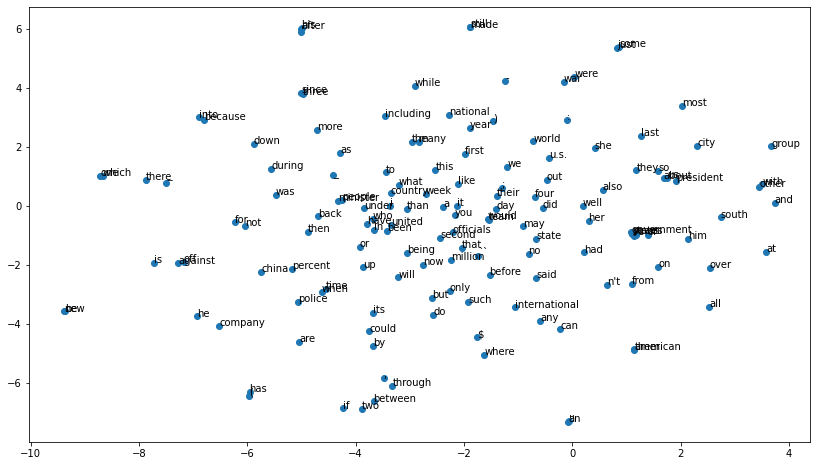

In [307]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
emmbed_dict = word2vector
distri = TSNE(n_components=2)
words = list(emmbed_dict.keys())
vectors = [emmbed_dict[word] for word in words]
y = distri.fit_transform(vectors[700:850])
plt.figure(figsize=(14,8))
plt.scatter(y[:, 0],y[:,1])
for label,x,y in zip(words,y[:, 0],y[:,1]):
  plt.annotate(label,xy=(x,y),xytext=(0,0),textcoords='offset points')
plt.show()

# Subject 10

## Text Preprocessing

## Euclidean Distance between Embeddings

In [118]:
def get_top_ind_eu(num, top):
    dist = {}
    for (i,d) in enumerate(embeddings):
        dist[i] =  np.linalg.norm(d-embeddings[num])
    dist = dict(sorted(dist.items(),key= lambda x:x[1]))
    return list(dist.keys())[:top]

In [134]:
def get_top_subj_eu(d, ind, top, printOutput=False):
    out = [d[i] for i in get_top_ind_eu(ind,top)]
    if printOutput:
        print('Input Subject: ', d[ind], '\n')
        for o in out:
            print('Output Subject: ', o)
    return out

In [135]:
get_top_subj_eu(data, 150, 10, True)

Input Subject:  Urgent: Immediate payment is required 

Output Subject:  Urgent: Immediate payment is required
Output Subject:  Account Alert: Your payment is due
Output Subject:  A payment is required on your account
Output Subject:  Account Alert: Your payment is scheduled
Output Subject:  Your QCard payment is due soon.
Output Subject:   Your payment is due soon!
Output Subject:  Your payment is due soon!
Output Subject:  Your next card payment is due ${MIN_PYMT_DUE_DT}. Here are easier ways to pay.
Output Subject:  Your account still needs a payment method…
Output Subject:  Your COVID-19 Payment Assistance Program has ended-your next payment is due ${PYMNT_DUE_DATE}.


['Urgent: Immediate payment is required',
 'Account Alert: Your payment is due',
 'A payment is required on your account',
 'Account Alert: Your payment is scheduled',
 'Your QCard payment is due soon.',
 ' Your payment is due soon!',
 'Your payment is due soon!',
 'Your next card payment is due ${MIN_PYMT_DUE_DT}. Here are easier ways to pay.',
 'Your account still needs a payment method…',
 'Your COVID-19 Payment Assistance Program has ended-your next payment is due ${PYMNT_DUE_DATE}.']

## Cosine Similarity

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
def cosine_sim(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [54]:
def get_top_ind_cos(num, top):
    dist = {}
    for (i,d) in enumerate(embeddings):
        dist[i] =  cosine_similarity(d.reshape(1,-1), embeddings[num].reshape(1,-1))[0][0]
    dist = dict(sorted(dist.items(),key= lambda x:x[1], reverse=True))
    return list(dist.keys())[:top]

In [55]:
def get_top_subj_cos(d, ind, top):
    
    print('Input Subject: ', d[ind], '\n')
    out = [d[i] for i in get_top_ind_cos(ind,top)]
    for o in out:
        print('Output Subject: ', o)

In [56]:
get_top_subj_cos(data, 1000, 10)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.7 µs
Input Subject:  It's a special summertime offer for ${dynamic1} employees. 

Output Subject:  It's a special summertime offer for ${dynamic1} employees.
Output Subject:   It's a special summertime offer for ${dynamic1}  employees.
Output Subject:  Thank you for being a customer. Here's a special offer.
Output Subject:  ${FirstName}, Here’s a special PayPal offer for you
Output Subject:  A special offer for you
Output Subject:  Just for you: A special DVR offer 
Output Subject:  Just for you: A special WiFi offer!
Output Subject:  Synchrony Bank has a special offer for Synchrony HOME Credit Cardholders.
Output Subject:  A special offer from Overstock for our best customers!
Output Subject:  Just for you: A special offer on the best services


## K Means Clustering

## Other Distance Metrics

In [159]:
from scipy.spatial.distance import cdist

In [162]:
d=cdist(data[:10000],data[:10000])

In [163]:
similarity_indexes = np.argsort(d,axis=0)

In [164]:
top10_similar=a[:,0:10]

In [165]:
top10_similar[10,:]

array([ 6674,   299, 11258, 10219,  4938,  6524,  7603,   362,  4206,
        9989])

In [170]:
for i, ranks in enumerate(top10_similar[90:100,:]):
    print('\n\nInput Subject: ', data[i], '\n\n')
    for k, j in enumerate(ranks):
        print('Output Subject ', k, ': ', data[j], '\n')



Input Subject:  Thank you for contacting Pagemodo 


Output Subject  0 :  Fall savings available at Victorville Chevrolet 

Output Subject  1 :  Ravens vs. Titans: Baltimore is the heavy favorite, still Tennessee is a 'real threat'  |  Many PG lawmakers won’t back Pimlico deal without Bowie track | Two arrested in shooting of 13-year-old girl 

Output Subject  2 :  Message created by RestApiSeriesTask TriggerMessage Series 1  

Output Subject  3 :  ${FirstName}, empieza a usar tu cuenta de PayPal 

Output Subject  4 :  Rate Limit Exceeded Alert in messages_v3 proxy 

Output Subject  5 :  ${TRU_SUNDAY_DYNAMIC_MAI_BCQ_219.OZ1.SUBJECTLINE} 

Output Subject  6 :  ${SubjectLine!'default'} 

Output Subject  7 :  Keep the birthday party going 🎈 

Output Subject  8 :  Get up to 50% off GoPro Gear 

Output Subject  9 :  Summary Report - Cashiering Request Needs Additional Information 2018-03-14 



Input Subject:  Pagemodo Tip: How to Keep Fans Coming Back 


Output Subject  0 :  [#assign LET

##  GRU Implementation

In [199]:
SOS_token = 0
EOS_token = 1

class SubjectLines:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index.keys():
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [200]:
def init_subjects(n):
    print("Creating subject classes...")
    
    input_subjects = SubjectLines()
    output_subjects = [SubjectLines() for i in range(n)]

    print("Done creating subject classes...")

    return input_subjects, output_subjects

In [201]:
from tqdm import tqdm

def prepareData(data, top_k=5, subLen=1000):
    
    input_sub, output_sub = init_subjects(top_k)   
    print("Read %s subjects" % len(data))
    clean_subjects = data
    print("Trimmed to %s subjects" % len(clean_subjects))
    
    print("Counting words...")
    output_subjects = []
    for i, clean_subject in enumerate(tqdm(clean_subjects)):
        if i<subLen:
            input_sub.addSentence(clean_subject)
            output = get_top_subj_eu(clean_subjects, i, top_k)  
            output_subjects.append(output)
            for i, _d in enumerate(output):
                output_sub[i].addSentence(_d)
        
    print("Counted words and saved input-output data")
    
    print(input_sub.n_words)
    for output_s in output_sub:
        print(output_s.n_words)
    
    return input_sub, output_sub, clean_subjects, output_subjects

In [202]:
len(data)

85004

In [203]:
input_sub, output_sub, input_subjects, output_subjects = prepareData(data, 5, 1000)

Creating subject classes...
Done creating subject classes...
Read 85004 subjects
Trimmed to 85004 subjects
Counting words...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 85004/85004 [11:33<00:00, 122.61it/s]

Counted words and saved input-output data
2827
2370
2194
2135
2137
2095


In [223]:
"under" in input_sub.word2index.keys()

True

In [204]:
print(random.choice(input_subjects))
print(random.choice(output_subjects))

barstools under ship free !
['quality lasts longer .', ' style that lasts forever classic !', 'naturally pretty flush of color that lasts lasts ', 'cyber monday lasts all week long', 'marriott executive apartments for longer stays']


In [172]:
print('\n\nInput Subject: ', data[10], '\n')
ranks = top10_similar[10,:]
for k, j in enumerate(ranks):
    print('Output Subject ', k, ': ', data[j], '\n')



Input Subject:  Publish Your Website Today- Free not Pub Day 8 

Output Subject  0 :  Your Sephora.com email address 

Output Subject  1 :  Quick Tip: Don't Forget Your Custom Domain - Prem Welcome - Enh D3 

Output Subject  2 :  [#assign NAMELIST = PatientName] [#assign NAMELIST = NAMELIST?split(",")] [#assign NAMEFIRST=NAMELIST[1]] [#assign NAMELAST=NAMELIST[0]]${NAMEFIRST?capitalize}, a smarter smile is still waiting. 

Output Subject  3 :  [#if UUID_Subject_Line?has_content]${UUID_Subject_Line}[#else]Your Daily Yahoo Stories for ${.now?date?string("EEEE")} [/#if] 

Output Subject  4 :  NEW Warrior & CCM Hockey Sticks! 

Output Subject  5 :  Your Sephora.com email address 

Output Subject  6 :  ${FIRST_NAME} ${LAST_NAME}, Update your business information so we can serve you better 

Output Subject  7 :  testdhyan 

Output Subject  8 :  Cuidando sus pasos. Mes 12. 

Output Subject  9 :  Dealer Name / Campaign Name / Campaign Id : Hometown Motors Volvo Test Account B / 5258544 has s

# Autoencoder + Decoder Models

## Model

In [146]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [147]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [148]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Training-2

### Autoencoder Training

In [309]:
## Customized
def indexesFromSentence(sub, sentence):
    return [sub.word2count[word] for word in sentence.split(' ')]


def tensorFromSentence(sub, sentence):
    indexes = indexesFromSentence(sub, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromSubs(input_subject, output, n):
    input_tensor = tensorFromSentence(input_sub, input_subject)
    target_tensors= [] 
    for i in range(n):
        target_tensors.append( tensorFromSentence( output_sub[i], output[i]) )
    return (input_tensor, target_tensors )

def tensorsFromSubsTar1(input_subject, k=0):
    input_tensor = tensorFromSentence(input_sub, input_subject)
    i = input_subjects.index(input_subject)
    target_tensors= tensorFromSentence(output_sub[k], output_subjects[i][k])
    return (input_tensor, target_tensors)

def tensorsFromInSub(input_subject):
    input_tensor = tensorFromSentence(input_sub, input_subject)
    return (input_tensor, input_tensor)

In [310]:
# Original
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [311]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [312]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [313]:
## Original
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, k=0):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = []
    for i in range(n_iters):
        inp = random.choice(input_subjects[:1000])
        while len(inp)>20:
            inp = random.choice(input_subjects[:1000])
        training_pairs.append(tensorsFromInSub(inp))
    criterion = nn.NLLLoss()

    for iter in tqdm(range(1, n_iters + 1)):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [315]:
hidden_size = 256
k=1
encoder2 = EncoderRNN(input_sub.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, input_sub.n_words, dropout_p=0.1).to(device)
# decoder1 = DecoderRNN(hidden_size, input_sub.n_words).to(device)

#### Training-1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:31<00:00, 65.99it/s]

2m 32s (- 0m 0s) (10000 100%) 0.1222


<Figure size 432x288 with 0 Axes>

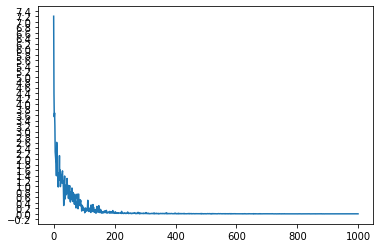

In [316]:
trainIters(encoder1, attn_decoder1, 10000, print_every=10000, plot_every=10, k=k)

In [317]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_sub, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(input_sub.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [318]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        inp = random.choice(input_subjects[:1000])
        
        pair = (inp, inp)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [319]:
evaluateRandomly(encoder1, attn_decoder1)

>  dealbuster alert ! . fleece . xmas pjs !
=  dealbuster alert ! . fleece . xmas pjs !
< <EOS>

> your rapid rewards anniversary points are coming
= your rapid rewards anniversary points are coming
< <EOS>

> bills vs tampa bay duelazo de la semana !
= bills vs tampa bay duelazo de la semana !
< outfits no postos less <EOS>

> chicago firefighter dies days after being injured battling fire in belmont central neighborhood
= chicago firefighter dies days after being injured battling fire in belmont central neighborhood
< <EOS>

> tune in tomorrow to hear from donation dollar s award winning creators
= tune in tomorrow to hear from donation dollar s award winning creators
< <EOS>

> garnissez la votre fa on nouvelle recette de p te biscuit tout usage base de plantes !
= garnissez la votre fa on nouvelle recette de p te biscuit tout usage base de plantes !
< not your postos less <EOS>

> memorial day savings starts now months special financing 
= memorial day savings starts now months spe

In [320]:
evaluateRandomly(encoder1, attn_decoder1)

> ebook new releases start a series for under 
= ebook new releases start a series for under 
< und not t <EOS>

> save big to off almost everything they need for spring !
= save big to off almost everything they need for spring !
< not ends or less <EOS>

> got used gear ? we want to buy it
= got used gear ? we want to buy it
< fall <EOS>

> ppp forgiveness new sba guidance is available
= ppp forgiveness new sba guidance is available
< <EOS>

> hotel temporarily closed due to government decision radisson blu hotel prague
= hotel temporarily closed due to government decision radisson blu hotel prague
< <EOS>

>  listo para hacer nuevos amigos ! mes .
=  listo para hacer nuevos amigos ! mes .
< make olhos postos <EOS>

> offer upgrade ! an extra off 
= offer upgrade ! an extra off 
< make jusqu coupon seu make <EOS>

> interested in talking to your doctor about self administered ig for cidp ?
= interested in talking to your doctor about self administered ig for cidp ?
< <EOS>

> deals o

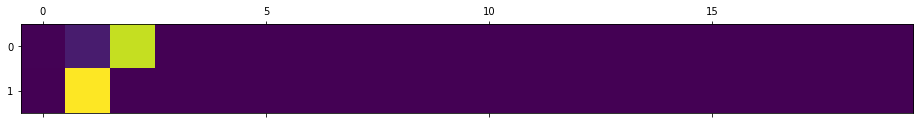

In [338]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, data[10])
plt.matshow(attentions.numpy())

In [340]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = summary report new coupon template 
output = olhos postos go make <EOS>
input =  d j son e anniversaire ! un cadeau pour vous !
output = outfits no coupon <EOS>
input = just for you get off at l .l .bean . limited time offer !
output = outfits no postos less <EOS>
input = brauchen sie geld f r ihre unternehmensfinanzierung ?
output = <EOS>


/tmp/ipykernel_31400/3159908345.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_31400/3159908345.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


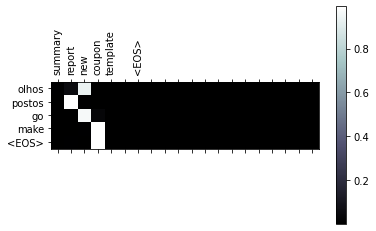

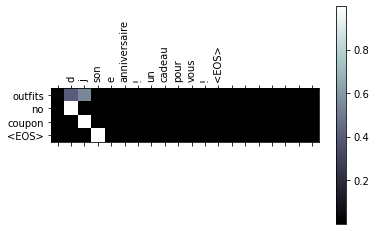

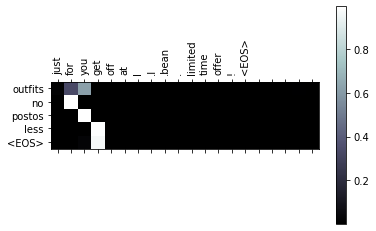

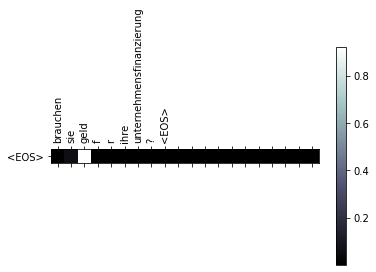

In [342]:
evaluateAndShowAttention(data[10])
evaluateAndShowAttention(data[11])
evaluateAndShowAttention(data[34])
evaluateAndShowAttention(data[53])

### Decoder Training

In [324]:
# Original

teacher_forcing_ratio = 0.5

def trainDecoder(input_tensor, target_tensor, encoder, decoder, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    decoder_optimizer.step()

    return loss.item() / target_length

In [325]:
## Original
def trainItersDecoder(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, k=0):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = []
    for i in range(n_iters):
        inp = random.choice(input_subjects[:1000])
        while len(inp)>20:
            inp = random.choice(input_subjects[:1000])
        training_pairs.append(tensorsFromSubsTar1(inp, k))
    criterion = nn.NLLLoss()

    for iter in tqdm(range(1, n_iters + 1)):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = trainDecoder(input_tensor, target_tensor, encoder,
                     decoder, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [326]:
hidden_size = 256
k=1
attn_decoder_all = [ AttnDecoderRNN(hidden_size, output_sub[i].n_words, dropout_p=0.1).to(device) 
                for i in range(5) ]
# decoder1 = DecoderRNN(hidden_size, input_sub.n_words).to(device)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.99it/s]


0m 22s (- 0m 0s) (1000 100%) 1.4146


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.60it/s]


0m 16s (- 0m 0s) (1000 100%) 1.2238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.24it/s]


0m 21s (- 0m 0s) (1000 100%) 1.4145


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.26it/s]


0m 23s (- 0m 0s) (1000 100%) 1.4995


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.46it/s]

0m 20s (- 0m 0s) (1000 100%) 1.5027


<Figure size 432x288 with 0 Axes>

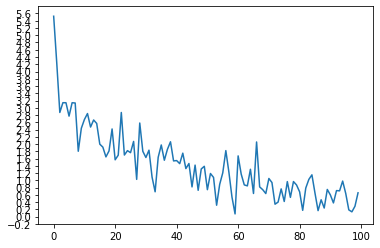

<Figure size 432x288 with 0 Axes>

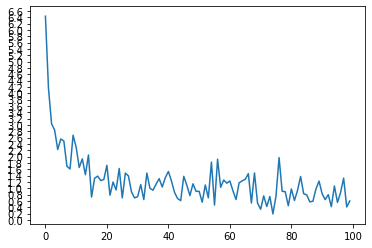

<Figure size 432x288 with 0 Axes>

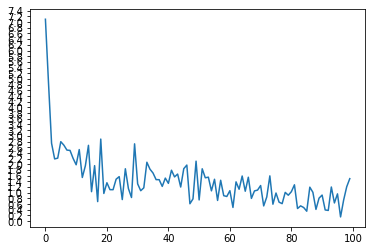

<Figure size 432x288 with 0 Axes>

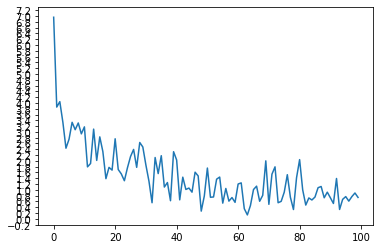

<Figure size 432x288 with 0 Axes>

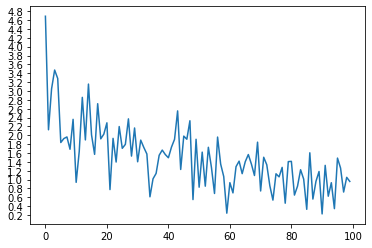

In [327]:
for i in range(5):
    trainItersDecoder(encoder1, attn_decoder_all[i], 1000, print_every=1000, plot_every=10, k=i)

In [328]:
def evaluateDecoder(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_sub, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(input_sub.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [329]:
def evaluateRandomlyDecoder(encoder, decoder, k=0):
    for i in range(n):
        inp = random.choice(input_subjects[:1000])
        ind = input_subjects.index(inp)
        out = output_subjects[ind][k]
        pair = (inp, out)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluateDecoder(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [330]:
for i in range(5):
    print('\n\nPart ', i, '\n')
    evaluateRandomly(encoder1, attn_decoder_all[i])



Part  0 

> get points with a new mortgage
= get points with a new mortgage
< couldn t see see see see enfamil anticip <EOS>

> activated . under
= activated . under
< <EOS>

> we want to know your thoughts
= we want to know your thoughts
< city olhos olhos <EOS>

> vous pourriez gagner de cashback sur votre prochain achat ligible 
= vous pourriez gagner de cashback sur votre prochain achat ligible 
< couldn t see see see see enfamil anticip <EOS>

> gl ckwunsch zu ihren !
= gl ckwunsch zu ihren !
< couldn t see see see see enfamil anticip <EOS>

>  argent place h tez vous . . .ouvrez d pensez et conomisez !
=  argent place h tez vous . . .ouvrez d pensez et conomisez !
< couldn t see see see see enfamil anticip <EOS>

> your credit limit has increased see how much !
= your credit limit has increased see how much !
< couldn t see see see see enfamil anticip <EOS>

> hurry ! off your next purchase
= hurry ! off your next purchase
< have late postos <EOS>

> introducing panthers perks 

In [331]:
for i in range(5):
    print('\n\nPart ', i, '\n')
    evaluateRandomly(encoder1, attn_decoder_all[i])



Part  0 

> hi firstname ?capitalize . here s more information
= hi firstname ?capitalize . here s more information
< couldn t see see see see enfamil anticip <EOS>

> stick to budget with ease huge holiday deals .
= stick to budget with ease huge holiday deals .
< <EOS>

> javier b ez turns sure out into run inning for chicago cubs
= javier b ez turns sure out into run inning for chicago cubs
< couldn t see see see see enfamil anticip <EOS>

> buy get off all learn to swim items
= buy get off all learn to swim items
< couldn t see see see see enfamil anticip <EOS>

> the latest buick suv has arrived
= the latest buick suv has arrived
< details olhos olhos <EOS>

> as a private client we may be able to lower your mortgage rate
= as a private client we may be able to lower your mortgage rate
< couldn t see see see see enfamil anticip <EOS>

> obtenez de rabais sur votre achat chez banana republic plus de remise en argent
= obtenez de rabais sur votre achat chez banana republic plus de

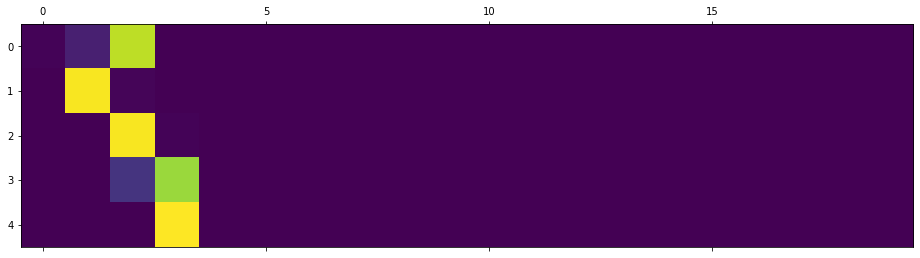

In [332]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, data[10])
plt.matshow(attentions.numpy())

In [333]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = summary report new coupon template 
output = olhos postos de olhos <EOS>
input = test jm military dtv 
output = go <EOS>
input = celebrate a magical moment with a star map from the night sky
output = <EOS>
input = willkommen zur ck mit exklusiven angeboten f r
output = <EOS>


/tmp/ipykernel_31400/3159908345.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_31400/3159908345.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


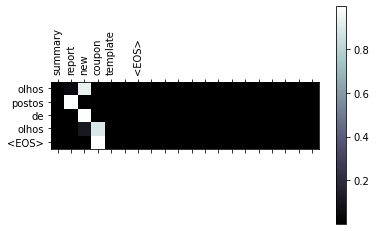

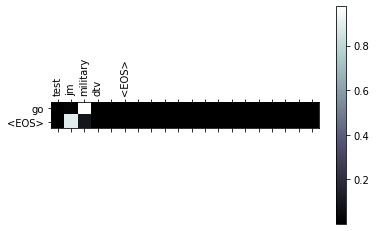

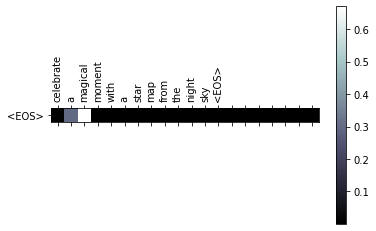

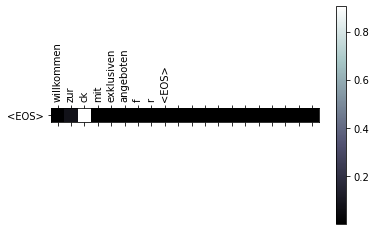

In [334]:
evaluateAndShowAttention(data[10])
evaluateAndShowAttention(data[244])
evaluateAndShowAttention(data[345])
evaluateAndShowAttention(data[543])

## Save Models

In [288]:
import pickle

In [294]:
f = open('encoder','wb')
pickle.dump(encoder1,f)
f.close()
f = open('decoder','wb')
pickle.dump(attn_decoder, f)
f.close()

In [298]:
f = open('encoder','rb')
e = pickle.load(f)
f.close()

In [299]:
d

[AttnDecoderRNN(
   (embedding): Embedding(2370, 256)
   (attn): Linear(in_features=512, out_features=20, bias=True)
   (attn_combine): Linear(in_features=512, out_features=256, bias=True)
   (dropout): Dropout(p=0.1, inplace=False)
   (gru): GRU(256, 256)
   (out): Linear(in_features=256, out_features=2370, bias=True)
 ),
 AttnDecoderRNN(
   (embedding): Embedding(2194, 256)
   (attn): Linear(in_features=512, out_features=20, bias=True)
   (attn_combine): Linear(in_features=512, out_features=256, bias=True)
   (dropout): Dropout(p=0.1, inplace=False)
   (gru): GRU(256, 256)
   (out): Linear(in_features=256, out_features=2194, bias=True)
 ),
 AttnDecoderRNN(
   (embedding): Embedding(2135, 256)
   (attn): Linear(in_features=512, out_features=20, bias=True)
   (attn_combine): Linear(in_features=512, out_features=256, bias=True)
   (dropout): Dropout(p=0.1, inplace=False)
   (gru): GRU(256, 256)
   (out): Linear(in_features=256, out_features=2135, bias=True)
 ),
 AttnDecoderRNN(
   (embe

In [297]:
f = open('decoder','rb')
d = pickle.load(f)
f.close()

In [5]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-02-03 21:45:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-02-03 21:45:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-02-03 21:45:23--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

100%[==

In [6]:
# !unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [5]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-02-03 21:45:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-02-03 21:45:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-02-03 21:45:23--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

100%[==

In [6]:
# !unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
